# Notebook to Investigate LSTM Performance Variance for Maritime Only Single Snow Type Model 

# Step 0 - Set up Notebook

In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from snowML.viz import download_metrics as dm
from snowML.datapipe.utils import snow_types as st
from snowML.datapipe.utils import get_geos as gg
from snowML.datapipe.utils import data_utils as du
from snowML.datapipe.utils import get_dem as gd

In [2]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Get MLFlow Metrics

In [3]:
run_dict = {} 
run_dict["Mar_custom"] = "7c840d1f855c4fa08e24979306259875"
run_dict["Mar_hybrid"] = "a956f9d680fa4e2fa0368f82e8f24d79"
run_dict["Mar_mae"] = "3fdb78d054fe49819aaf4f62a25062cf"
run_dict["Mar_mse"] = "753f3cb9fe584239959a64610d50bae8"
#run_dict["Mar_ucla_mse"] = "11cd6030ad934a8b8302a35a38e6aa30" # Incomplete Run
run_dict["Mar_ucls_mse"] = "868e4cf2f84d4362a548b4ad99052ebf"
run_dict["Mar_ucla_hum_mse"] = "6375eefddd0e4f08914fb164f7be131a"
run_dict["Mar_custom_.02"] = "849719c78aaf4a4f87d4478d36f97466"
run_dict["Mar_custome_.03"] = "84b2fc6ddde84f9c93a2e9ce47cfde5c"
run_dict["Mar_custom_.04"] = "c05b6e79957b4530967b4b050c32e569"
run_dict["Mar_custom_.05"] = "7d6d22bdfe9046d885fe530a9f971a97"
run_dict["Mar_custom_,04_redo"] = "c98c5d11dd5b42048178ba4ced9b2f2c"
run_dict["Mar_mse_redo"] = "5be42200e13e4237ad24d7a4e763e495"
run_dict["mar_cust_05_redo"] = "0c03e50f7f50491ba811cae6fde82746"
run_dict["Mar_kge_only"] = "e0c3a29975a84c5fb2bc0283dfe649cc"
run_dict["Mar_custom_04_lowlr"] = "1aa6fc56f0a34528acbc3f58dc2b053e"
run_dict["Mar_mse_lowlr"]  = "5ee26d80a1224074bb5f571cf933b2b9"
run_dict

{'Mar_custom': '7c840d1f855c4fa08e24979306259875',
 'Mar_hybrid': 'a956f9d680fa4e2fa0368f82e8f24d79',
 'Mar_mae': '3fdb78d054fe49819aaf4f62a25062cf',
 'Mar_mse': '753f3cb9fe584239959a64610d50bae8',
 'Mar_ucls_mse': '868e4cf2f84d4362a548b4ad99052ebf',
 'Mar_ucla_hum_mse': '6375eefddd0e4f08914fb164f7be131a',
 'Mar_custom_.02': '849719c78aaf4a4f87d4478d36f97466',
 'Mar_custome_.03': '84b2fc6ddde84f9c93a2e9ce47cfde5c',
 'Mar_custom_.04': 'c05b6e79957b4530967b4b050c32e569',
 'Mar_custom_.05': '7d6d22bdfe9046d885fe530a9f971a97',
 'Mar_custom_,04_redo': 'c98c5d11dd5b42048178ba4ced9b2f2c',
 'Mar_mse_redo': '5be42200e13e4237ad24d7a4e763e495',
 'mar_cust_05_redo': '0c03e50f7f50491ba811cae6fde82746',
 'Mar_kge_only': 'e0c3a29975a84c5fb2bc0283dfe649cc',
 'Mar_custom_04_lowlr': '1aa6fc56f0a34528acbc3f58dc2b053e',
 'Mar_mse_lowlr': '5ee26d80a1224074bb5f571cf933b2b9'}

In [4]:
# create a dictionary of dataframes corresponding to the run_id shortname uploading from local files 
# Assumes you have already run the "download metrics" script from the snowML.Scripts package to save the metrics to local files
df_dict = {}
for key in run_dict.keys(): 
    run_id = run_dict[key]
    file = f"../../mlflow_data/run_id_data/metrics_from_{run_id}.csv"
    df_metrics = pd.read_csv(file)
    #print(df_metrics.shape)
    df_dict[key] = df_metrics


In [5]:
# display example
#key = "Elev_and_FC_30"
key = "Mar_custom_.04"
df_metrics = df_dict[key]
print(df_metrics.shape)
df_metrics


(12320, 3)


,Metric,Step,Value
0,test_kge_170200090101,0,0.852110
1,test_kge_170200090101,1,0.482543
2,test_kge_170200090101,2,0.828332
3,test_kge_170200090101,3,0.466931
4,test_kge_170200090101,4,0.701835
...,...,...,...
12315,test_mse_170200100203,5,0.008819
12316,test_mse_170200100203,6,0.008842
12317,test_mse_170200100203,7,0.008155
12318,test_mse_170200100203,8,0.007106


# Step 2 - Functions to Summarize Metrics 

In [6]:
# function to extract only a specific metric by suffix
def extract_metric_by_suffix(df, metric_name, step = False):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric, Valuem and optionally Step columns."""
    if step: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', "Step",'Value']].sort_values(by='Metric')
    else: 
        return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

In [7]:
# function to extract only a specific metric by prefix
def extract_metric_by_prefix(df, prefix, step=False):
    """Extracts rows where the Metric column begins with 'prefix' and returns only Metric, Value and optionally step columns."""
    if step:
        return df[df['Metric'].str.startswith(prefix)][['Metric', "Step", 'Value']].sort_values(by='Metric')
    else:
        return df[df['Metric'].str.startswith(prefix)][['Metric', 'Value']].sort_values(by='Metric')

# Step 3 - Define Some Plotting Functions

In [8]:
def plot_step_metrics(df, title='Metrics vs Step', save = True):
    """Plots all columns in the given DataFrame against the index with a legend."""
    
    plt.figure(figsize=(10, 5))
    
    # Plot each column
    for column in df.columns:
        plt.plot(df.index, df[column], marker='o', linestyle='-', label=column)
    
    # Labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    if save: 
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')
    
    plt.show()


In [9]:
def plot_median_comparison(df_dict, title="Median_Metric_Comparison_By_Epoch_And_Run", save = True):
    """Plots the 'median' column against the index for each DataFrame in the dictionary."""
    
    plt.figure(figsize=(10, 5))
    
    # Plot each DataFrame
    for label, df in df_dict.items():
        plt.plot(df.index, df['median'], marker='o', linestyle='-', label=label)
    
    # Labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Median Value')
    plt.title(title)
    #plt.ylim(-1, 1)  # Set fixed y-axis range
    plt.legend()
    plt.grid(True)
    
    if save: 
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')

    plt.show()

# Step 4 Examine Test-KGE For An Example Run 

In [10]:
df_filtered = extract_metric_by_prefix(df_metrics, "test_kge", step=True)
summary = df_filtered.groupby("Step")["Value"].agg(["median", "mean", "min", "max", "std"])
summary

,median,mean,min,max,std
Step,,,,,
0,0.864625,0.798605,-0.101026,0.978853,0.173324
1,0.862473,0.818474,0.351559,0.969523,0.132572
2,0.861032,0.822813,0.309683,0.971805,0.125679
3,0.864359,0.823352,0.343217,0.976211,0.127120
4,0.859894,0.821655,0.363406,0.966573,0.124868
5,0.866821,0.824698,0.307113,0.972931,0.125698
6,0.866805,0.824787,0.336143,0.967170,0.127964
7,0.859889,0.824560,0.374173,0.973261,0.124465
8,0.863057,0.823210,0.384011,0.975770,0.124066


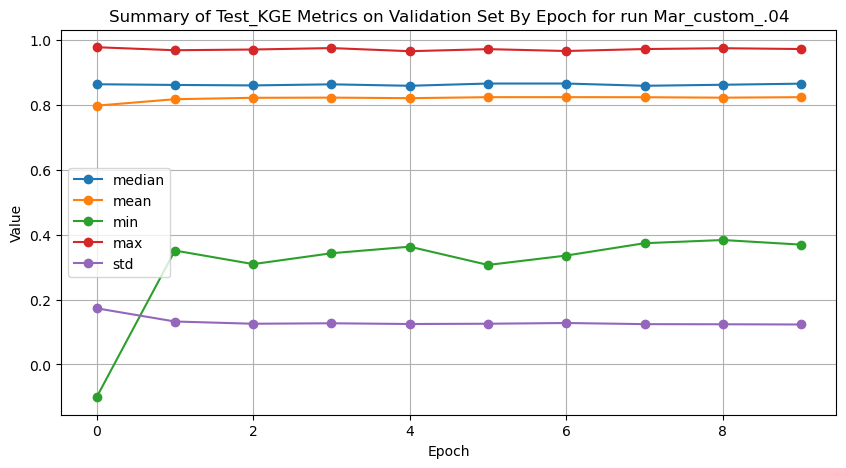

In [11]:
ttl = f"Summary of Test_KGE Metrics on Validation Set By Epoch for run {key}"
plot_step_metrics(summary, title = ttl, save = False)

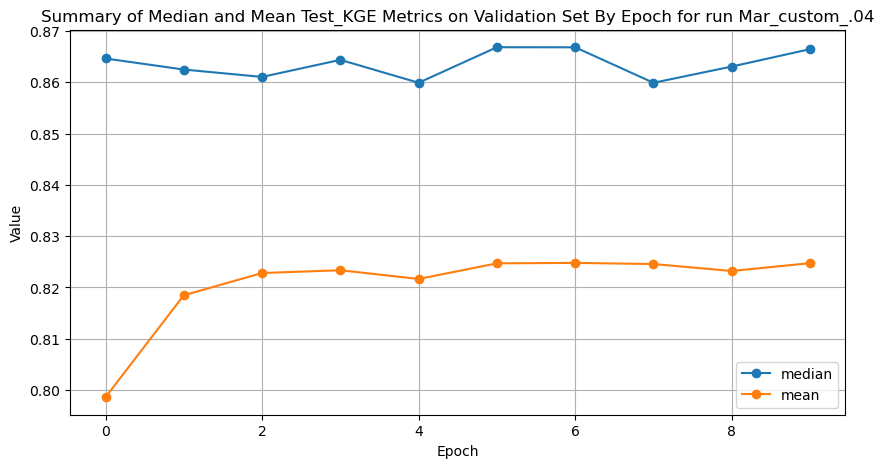

In [12]:
# zoom in on just the median and the mean
ttl = f"Summary of Median and Mean Test_KGE Metrics on Validation Set By Epoch for run {key}" 
summary_slim = summary[["median", "mean"]]
plot_step_metrics(summary_slim, title = ttl, save = False)

# Step 4B - Test Recur KGE for a Sample Run

In [13]:
key = "Mar_DI7"
df_filtered_recur = extract_metric_by_prefix(df_metrics, "test_recur_kge", step=True)
summary_recur = df_filtered_recur.groupby("Step")["Value"].agg(["median", "mean", "min", "max", "std"])
summary_recur

,median,mean,min,max,std
Step,,,,,


# Step 5 - Compare Runs

In [14]:
df_summary_dict = {}
for key in run_dict.keys(): 
    df_metrics = df_dict[key]
    df_filtered = extract_metric_by_prefix(df_metrics, "test_kge", step=True)
    summary_df = df_filtered.groupby("Step")["Value"].agg(["median"])
    df_summary_dict[key] = summary_df

    # KGE Predict Recur    
    df_filtered_recur = extract_metric_by_prefix(df_metrics, "test_recur_kge", step=True)
    summary_recur = df_filtered_recur.groupby("Step")["Value"].agg(["median", "mean", "min", "max", "std"])
    if not summary_recur.empty:
        df_summary_dict[key+"+Recur"] = summary_recur
  

In [15]:
def filter_dict(df_summary_dict, excluded_keys):
    return {k: v for k, v in df_summary_dict.items() if k not in excluded_keys}


In [16]:
def filter_dict_inc(df_summary_dict, included_keys):
    return {k: v for k, v in df_summary_dict.items() if k in included_keys}

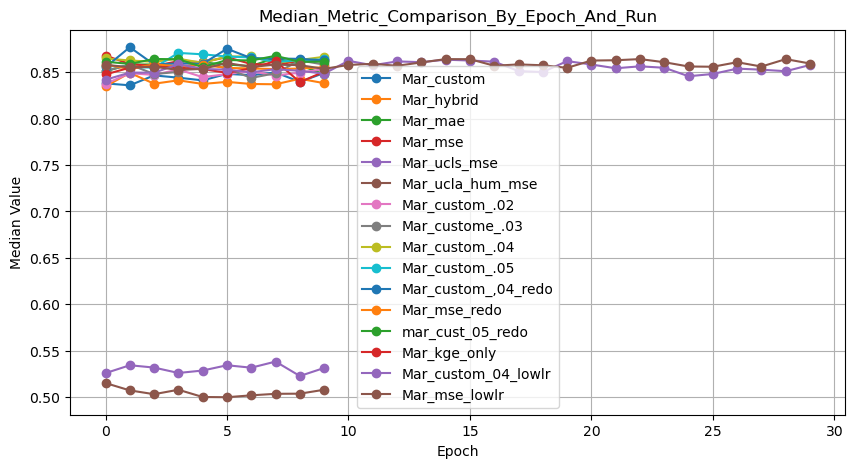

In [17]:
plot_median_comparison(df_summary_dict, title="Median_Metric_Comparison_By_Epoch_And_Run", save = False)

In [18]:
# MSE
df_summary_dict_mse = {}
for key in run_dict.keys(): 
    df_metrics = df_dict[key] 
    df_filtered_mse = extract_metric_by_prefix(df_metrics, "test_mse", step=True)
    summary_mse = df_filtered_mse.groupby("Step")["Value"].agg(["median", "mean", "min", "max", "std"])
    df_summary_dict_mse[key] = summary_mse

In [19]:
# Train MSE 
df_summary_dict_train_mse = {}
for key in run_dict.keys(): 
    df_metrics = df_dict[key] 
    df_filtered_mse_tr = extract_metric_by_prefix(df_metrics, "train_mse", step=True)
    summary_mse_tr = df_filtered_mse_tr.groupby("Step")["Value"].agg(["median", "mean", "min", "max", "std"])
    df_summary_dict_train_mse[key] = summary_mse_tr


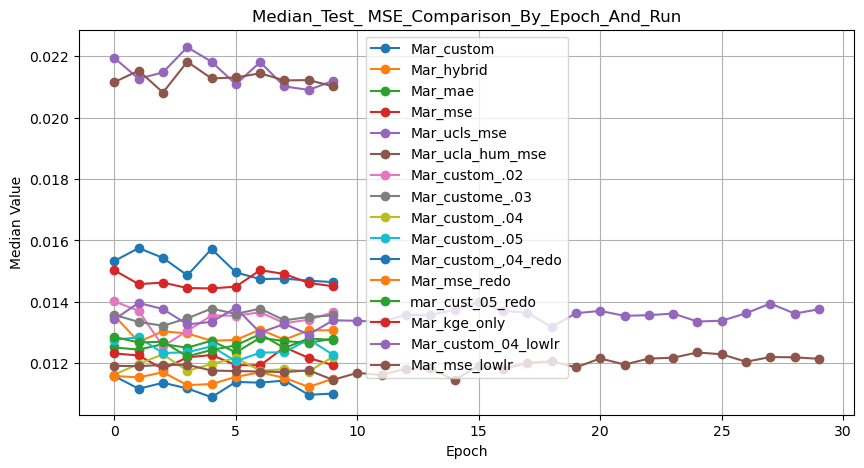

In [20]:
plot_median_comparison(df_summary_dict_mse, title="Median_Test_ MSE_Comparison_By_Epoch_And_Run", save = False)

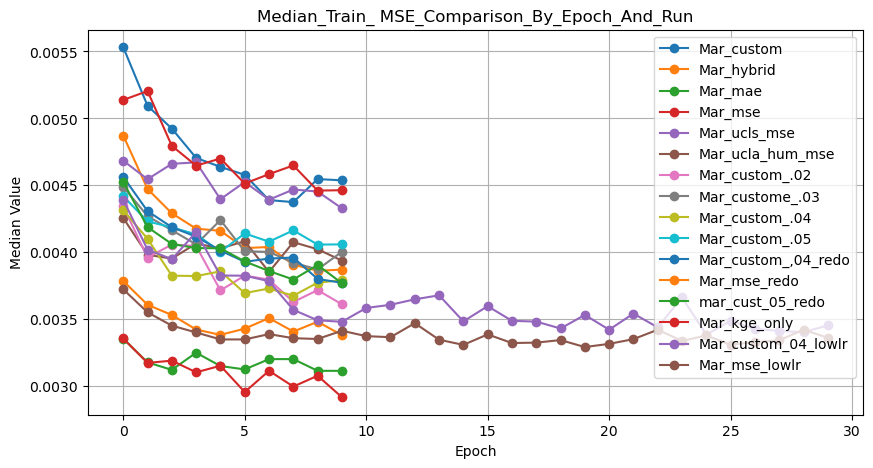

In [21]:
plot_median_comparison(df_summary_dict_train_mse, title="Median_Train_ MSE_Comparison_By_Epoch_And_Run", save = False)

# Zero in on Runs of Most interest

In [22]:
df_summary_dict.keys()

dict_keys(['Mar_custom', 'Mar_hybrid', 'Mar_mae', 'Mar_mse', 'Mar_ucls_mse', 'Mar_ucla_hum_mse', 'Mar_custom_.02', 'Mar_custome_.03', 'Mar_custom_.04', 'Mar_custom_.05', 'Mar_custom_,04_redo', 'Mar_mse_redo', 'mar_cust_05_redo', 'Mar_kge_only', 'Mar_custom_04_lowlr', 'Mar_mse_lowlr'])

In [23]:
excluded_keys = ["Mar_ucla_hum_mse", "Mar_ucls_mse", "Mar_custom", "Mar_custom_.02", "Mar_custome_.03", "Mar_kge_only", "Mar_hybrid", "Mar_mae"] 
sum_dict_small = filter_dict(df_summary_dict, excluded_keys)

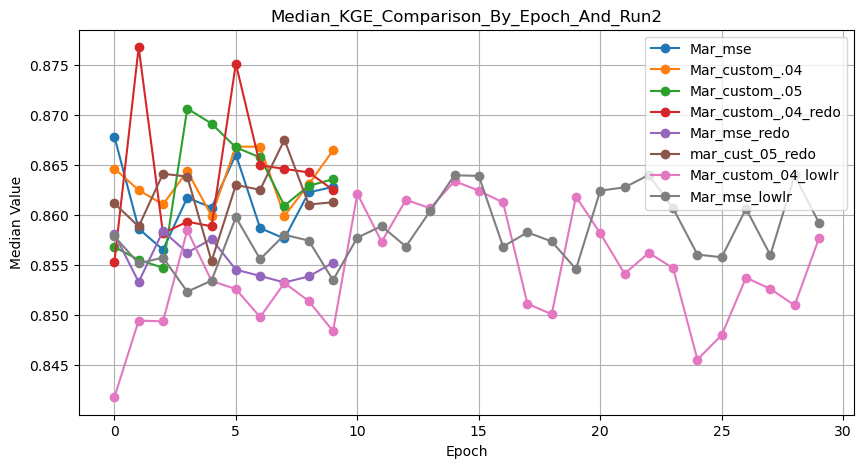

In [24]:
plot_median_comparison(sum_dict_small, title="Median_KGE_Comparison_By_Epoch_And_Run2", save = False)

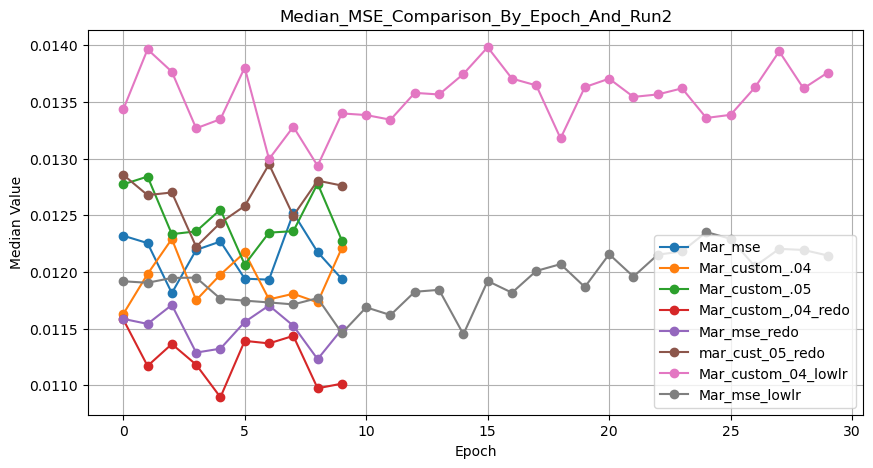

In [25]:
df_summary_dict_mse_small = filter_dict(df_summary_dict_mse, excluded_keys)
plot_median_comparison(df_summary_dict_mse_small, title="Median_MSE_Comparison_By_Epoch_And_Run2", save = False)

# Determine max kge for all runs

In [26]:
all_keys = list(df_summary_dict.keys())
for key in all_keys: 
    df = df_summary_dict[key]
    medians = df["median"]
    idx = medians.idxmax()  # Get the index of the max median value
    highest_median = np.max(medians)
    print(f"for run {key} the highest median test kge achieved was {highest_median:.3f} in epoch {idx}")

for run Mar_custom the highest median test kge achieved was 0.850 in epoch 7
for run Mar_hybrid the highest median test kge achieved was 0.849 in epoch 1
for run Mar_mae the highest median test kge achieved was 0.865 in epoch 7
for run Mar_mse the highest median test kge achieved was 0.868 in epoch 0
for run Mar_ucls_mse the highest median test kge achieved was 0.538 in epoch 7
for run Mar_ucla_hum_mse the highest median test kge achieved was 0.515 in epoch 0
for run Mar_custom_.02 the highest median test kge achieved was 0.853 in epoch 9
for run Mar_custome_.03 the highest median test kge achieved was 0.862 in epoch 8
for run Mar_custom_.04 the highest median test kge achieved was 0.867 in epoch 5
for run Mar_custom_.05 the highest median test kge achieved was 0.871 in epoch 3
for run Mar_custom_,04_redo the highest median test kge achieved was 0.877 in epoch 1
for run Mar_mse_redo the highest median test kge achieved was 0.858 in epoch 2
for run mar_cust_05_redo the highest median te

# NOtes

MSD did best, but custom .04 came close What's up with UCLA data.  Try Toloumne w/ UCLA data.  